1. Pull the images csv from callisto
2. Get the list of HPA genes with cell-cycle plots
3. Put those into a dataset folder
4. Run the main file to clean up and segment the data (are there masks already?)

## Ensure Kernel is data-prep until the mask processing step is complete. If using implicit, just rerun this first section.

In [1]:
import torch
import os
from pathlib import Path
import csv
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

DATA_DIR = Path('/data/ishang/HPA-CC-dataset/')
NAME = "512_min_max"
ARCHIVE = "/data/HPA-IF-images/"
USER = "ishangaur"
TARGET = {
    "username": "ishang",
    "hostname": "sscb-a100.scilifelab.se",
}

In [2]:
os.makedirs(DATA_DIR, exist_ok=True)
print(f"{str(DATA_DIR)} has {len(list(DATA_DIR.iterdir()))} files")


/data/ishang/HPA-CC-dataset has 70 files


In [3]:
df = pd.read_csv(Path.cwd() / 'ifimages_v23.csv')
print(df.columns)
df.head()

Index(['filename', 'jpg_prefix', 'if_plate_id', 'position', 'sample', 'status',
       'Image status name', 'locations', 'staining characteristics',
       'unspecific', 'antibody', 'ensembl_ids', 'gene_names', 'atlas_name',
       'versions', 'earliest_version', 'first_released', 'latest_version',
       'Spatial cell cycle', 'Intensity cell cycle', 'Annotated cell cycle',
       'gain', 'x_pos', 'y_pos', 'z_pos', 'Experiment state', 'Ab state',
       'Max tpm', 'Finished in genes', 'Protocol',
       'Gene reliability (in release)', 'Gene reliability (lims)',
       'Cell count', 'well_location_predictions_all'],
      dtype='object')


filename                                         jpg_prefix  \
0  /archive/1/1_A1_1_   https://lims.proteinatlas.org/images/992/1_A1_1_   
1  /archive/1/1_A1_2_   https://lims.proteinatlas.org/images/992/1_A1_2_   
2  /archive/1/1_A3_1_  https://lims.proteinatlas.org/images/2899/1_A3_1_   
3  /archive/1/1_A3_2_  https://lims.proteinatlas.org/images/2899/1_A3_2_   
4  /archive/1/1_A6_1_   https://lims.proteinatlas.org/images/609/1_A6_1_   

   if_plate_id position  sample  status         Image status name  \
0            1       A1       1      35  Annotated / Proteinatlas   
1            1       A1       2      35  Annotated / Proteinatlas   
2            1       A3       1      35  Annotated / Proteinatlas   
3            1       A3       2      35  Annotated / Proteinatlas   
4            1       A6       1      35  Annotated / Proteinatlas   

                                locations staining characteristics  \
0                         Golgi apparatus                      NaN   
1                         Golgi apparatus                      NaN   
2                     Cytosol,Nucleoplasm                      NaN   
3                     Cytosol,Nucleoplasm                      NaN   
4  Endoplasmic reticulum,Nuclear membrane                      NaN   

   unspecific  ... z_pos Experiment state     Ab state Max tpm  \
0         0.0  ...   NaN      IF_FINISHED  IF_FINISHED   16.13   
1         0.0  ...   NaN      IF_FINISHED  IF_FINISHED   16.13   
2         0.0  ...   NaN      IF_FINISHED  IF_FINISHED    2.74   
3         0.0  ...   NaN      IF_FINISHED  IF_FINISHED    2.74   
4         0.0  ...   NaN      IF_FINISHED  IF_FINISHED   81.38   

  Finished in genes  Protocol Gene reliability (in release)  \
0   ENSG00000066455       PFA                     Supported   
1   ENSG00000066455       PFA                     Supported   
2   ENSG00000183092       PFA                      Approved   
3   ENSG00000183092       PFA                      Approved   
4   ENSG00000102119       PFA                      Enhanced   

   Gene reliability (lims) Cell count well_location_predictions_all  
0                Supported        7.0                           NaN  
1                Supported        6.0                           NaN  
2                 Approved        4.0                           NaN  
3                 Approved        6.0                           NaN  
4                 Enhanced        5.0                           NaN  

[5 rows x 34 columns]

In [4]:
CCD_prots = ["DUSP19", "DUSP18", "PAPSS1", "N6AMT1", "PHLDB1", "FLI1", "TTC21B", "PC", "UGDH", 
             "ORC6", "ZNF32", "CCNE1", "CCNB1", "AURKB", "BUB1B", "DPH2", "GMNN", "CDT1", "ANLN"]
# ccd_rows = df["gene_names"].isin(CCD_prots)
ccd_rows = df["gene_names"].isin(CCD_prots) & df["atlas_name"].isin(["U2OS"])
# ccd_rows = df["gene_names"].isin(CCD_prots) & df["atlas_name"].isin(["U2OS"]) & df["Gene reliability (lims)"].isin(["Approved", "Enhanced"])
# ccd_df = df[ccd_rows][["filename", "jpg_prefix", "if_plate_id", "position", "sample", "gene_names",
#                        'status', 'Image status name', 'locations', 'staining characteristics', 'unspecific',
#                        'antibody', "atlas_name", "Cell count", 'Gene reliability (in release)', 'Gene reliability (lims)']]
ccd_df = df[ccd_rows][["filename", "jpg_prefix", "if_plate_id", "position", "sample", "gene_names",
                       'locations', 'antibody', "atlas_name", "Cell count"]]
print(f"Missing proteins, {set(CCD_prots) - set(ccd_df['gene_names'])}")
ccd_df

Missing proteins, {'TTC21B'}


filename  \
6071        /archive/91/91_H6_1_   
6072        /archive/91/91_H6_2_   
9033      /archive/148/148_F6_1_   
9034      /archive/148/148_F6_2_   
14254     /archive/247/247_C1_1_   
14255     /archive/247/247_C1_2_   
29928     /archive/581/581_B5_1_   
29929     /archive/581/581_B5_3_   
30008     /archive/582/582_D9_1_   
30009     /archive/582/582_D9_2_   
31364    /archive/613/613_B12_1_   
31365    /archive/613/613_B12_2_   
33466     /archive/645/645_D4_1_   
33467     /archive/645/645_D4_2_   
33980     /archive/663/663_E2_1_   
33981     /archive/663/663_E2_5_   
34084     /archive/667/667_A5_1_   
34085     /archive/667/667_A5_2_   
34967     /archive/717/717_E6_2_   
34968     /archive/717/717_E6_3_   
35947     /archive/738/738_H7_1_   
35948     /archive/738/738_H7_3_   
37044     /archive/760/760_B3_1_   
37045     /archive/760/760_B3_2_   
37654     /archive/771/771_A3_1_   
37655     /archive/771/771_A3_3_   
38946     /archive/795/795_H7_1_   
38947     /archive/795/795_H7_2_   
41160     /archive/845/845_A6_1_   
41161     /archive/845/845_A6_3_   
41918     /archive/861/861_B8_1_   
41919     /archive/861/861_B8_2_   
44983    /archive/932/932_C11_1_   
44984    /archive/932/932_C11_2_   
45279     /archive/945/945_B4_1_   
45280     /archive/945/945_B4_2_   
48323   /archive/1006/1006_A5_3_   
48324   /archive/1006/1006_A5_8_   
49705  /archive/1037/1037_F11_1_   
49706  /archive/1037/1037_F11_2_   
50326   /archive/1049/1049_D8_1_   
50327   /archive/1049/1049_D8_2_   
63912   /archive/1406/1406_G6_2_   
63913   /archive/1406/1406_G6_5_   
68188   /archive/1562/1562_C6_3_   
68189   /archive/1562/1562_C6_5_   
68248  /archive/1565/1565_B11_1_   
68249  /archive/1565/1565_B11_2_   
70824   /archive/1671/1671_B6_2_   
70825   /archive/1671/1671_B6_5_   
73712   /archive/1773/1773_B9_5_   
73713   /archive/1773/1773_B9_7_   
73770   /archive/1773/1773_G2_1_   
73771   /archive/1773/1773_G2_3_   
75660  /archive/1841/1841_G11_4_   
75661  /archive/1841/1841_G11_6_   
77334   /archive/1888/1888_C4_1_   
77335   /archive/1888/1888_C4_2_   
77846   /archive/1894/1894_C1_1_   
77847   /archive/1894/1894_C1_6_   

                                              jpg_prefix  if_plate_id  \
6071   https://lims.proteinatlas.org/images/8419/91_H...           91   
6072   https://lims.proteinatlas.org/images/8419/91_H...           91   
9033   https://lims.proteinatlas.org/images/21501/148...          148   
9034   https://lims.proteinatlas.org/images/21501/148...          148   
14254  https://lims.proteinatlas.org/images/18169/247...          247   
14255  https://lims.proteinatlas.org/images/18169/247...          247   
29928  https://lims.proteinatlas.org/images/38448/581...          581   
29929  https://lims.proteinatlas.org/images/38448/581...          581   
30008  https://lims.proteinatlas.org/images/36656/582...          582   
30009  https://lims.proteinatlas.org/images/36656/582...          582   
31364  https://lims.proteinatlas.org/images/11458/613...          613   
31365  https://lims.proteinatlas.org/images/11458/613...          613   
33466  https://lims.proteinatlas.org/images/47328/645...          645   
33467  https://lims.proteinatlas.org/images/47328/645...          645   
33980  https://lims.proteinatlas.org/images/115/663_E...          663   
33981  https://lims.proteinatlas.org/images/115/663_E...          663   
34084  https://lims.proteinatlas.org/images/308/667_A...          667   
34085  https://lims.proteinatlas.org/images/308/667_A...          667   
34967  https://lims.proteinatlas.org/images/47327/717...          717   
34968  https://lims.proteinatlas.org/images/47327/717...          717   
35947  https://lims.proteinatlas.org/images/43922/738...          738   
35948  https://lims.proteinatlas.org/images/43922/738...          738   
37044  https://lims.proteinatlas.org/images/49977/760...          760   
37045  https://lims.proteinatlas.org/images/49977/760...          760   
37

# Dataset Preparation

In [25]:
# remove /archive/ from all rows of "filename" column in ccd_df
print(ccd_df["filename"].iloc[0])
ccd_df["filename"] = ccd_df["filename"].apply(lambda x: x.replace("/archive/", ""))
print(ccd_df["filename"].iloc[0])

# now add a *.png to each so we glob all the images in the folder
ccd_df["filename"] = ccd_df["filename"].apply(lambda x: x + "*.png")
ccd_df["filename"].iloc[0]

/archive/91/91_H6_1_
91/91_H6_1_


'91/91_H6_1_*.png'

In [26]:
# form an scp command to copy all the images to the data dir
# the filenames need to be in the form ARCHIVE/{filename1,filename2,...}
file_endings = ["blue", "green", "red", "yellow"]
images = []
for filename in ccd_df["filename"]:
    for ending in file_endings:
        images.append(filename.replace("*", ending))


In [27]:
master_socket = f"SSHSOCKET=~/.ssh/{TARGET['username']}@{TARGET['hostname']}"
master_ssh = f"ssh -M -f -N -o ControlPath=$SSHSOCKET {TARGET['username']}@{TARGET['hostname']}"
file_transfer = f"scp -o ControlPath=$SSHSOCKET {ARCHIVE}{'{' + ','.join(images)+'}'} {TARGET['username']}@{TARGET['hostname']}:{DATA_DIR}"
close_master = f"ssh -S $SSHSOCKET -O exit {TARGET['username']}@{TARGET['hostname']}"

print("Run the following commands from the machine with the data:")
print(master_socket)
print(master_ssh)
print(file_transfer)
print(close_master)

Run the following commands from the machine with the data:
SSHSOCKET=~/.ssh/ishang@sscb-a100.scilifelab.se
ssh -M -f -N -o ControlPath=$SSHSOCKET ishang@sscb-a100.scilifelab.se
scp -o ControlPath=$SSHSOCKET /data/HPA-IF-images/{91/91_H6_1_blue.png,91/91_H6_1_green.png,91/91_H6_1_red.png,91/91_H6_1_yellow.png,91/91_H6_2_blue.png,91/91_H6_2_green.png,91/91_H6_2_red.png,91/91_H6_2_yellow.png,148/148_F6_1_blue.png,148/148_F6_1_green.png,148/148_F6_1_red.png,148/148_F6_1_yellow.png,148/148_F6_2_blue.png,148/148_F6_2_green.png,148/148_F6_2_red.png,148/148_F6_2_yellow.png,247/247_C1_1_blue.png,247/247_C1_1_green.png,247/247_C1_1_red.png,247/247_C1_1_yellow.png,247/247_C1_2_blue.png,247/247_C1_2_green.png,247/247_C1_2_red.png,247/247_C1_2_yellow.png,581/581_B5_1_blue.png,581/581_B5_1_green.png,581/581_B5_1_red.png,581/581_B5_1_yellow.png,581/581_B5_3_blue.png,581/581_B5_3_green.png,581/581_B5_3_red.png,581/581_B5_3_yellow.png,582/582_D9_1_blue.png,582/582_D9_1_green.png,582/582_D9_1_red.png,58

In [28]:
# check that the number of files in the data dir is the same as the number of images
print(f"{str(DATA_DIR)} has {len(list(DATA_DIR.iterdir()))} files, expected {len(ccd_df)*4}")

/data/ishang/HPA-CC-dataset has 240 files, expected 240


In [30]:
# make folders for each well_positions combination, and move the images into them
# in other words, these are all images with the same prefix: {if_plate_id}_{position}_{sample}_{channel}.png
# we want to move them into a folder called {if_plate_id}_{position}
try:
    for index, row in ccd_df.iterrows():
        folder_name = "_".join([str(row["if_plate_id"]), str(row["position"])])
        sample = str(row["sample"])
        os.makedirs(DATA_DIR / folder_name, exist_ok=True)
        for channel in file_endings:
            image_name = folder_name + f"_{sample}_{channel}.png"
            os.rename(DATA_DIR / image_name, DATA_DIR / folder_name / image_name)
except FileNotFoundError:
    print("FileNotFoundError: probably because the files have already been moved")

# check that the number of files in the data dir is the same as the number of images and that no images remain
print(f"{str(DATA_DIR)} has {len(list(DATA_DIR.iterdir()))} files")
total_images = 0
for folder in DATA_DIR.iterdir():
    if not folder.is_dir():
        continue
    total_images += len(list(folder.iterdir()))
print(f"{str(DATA_DIR)} has {total_images} images")

FileNotFoundError: probably because the files have already been moved
/data/ishang/HPA-CC-dataset has 30 files
/data/ishang/HPA-CC-dataset has 240 images


# Data Processing

At this point we need to make an hpa_cc_config.py config file like the non-well fucci config

In [31]:
!python main.py --data_dir $DATA_DIR --config hpa_cc_config.py --name $NAME --image_mask_cache --rebuild

Using device cuda:7
Caching composite images and getting segmentation masks
Creating image path index at: /data/ishang/HPA-CC-dataset/data-folder.txt
Number of target paths found: 30
please compile abn
Getting masks:  93%|██████████████████████████▏ | 28/30 [05:21<00:22, 11.30s/it]Mask mismatch for /data/ishang/HPA-CC-dataset/1562_C6, nuclei: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24], cell: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Getting masks: 100%|████████████████████████████| 30/30 [05:49<00:00, 11.64s/it]


## Switch to implicit kernel!

In [5]:
!python main.py --data_dir $DATA_DIR --config hpa_cc_config.py --name 512_min_max --clean_masks --normalize --single_cell --rgb --dino_cls_ref

Using device cuda:7
Cleaning masks
Cleaning masks:   3%|▉                           | 1/30 [00:02<01:02,  2.15s/it]

Cleaning masks: 100%|███████████████████████████| 30/30 [00:56<00:00,  1.90s/it]
Fraction removed: 0.0
Total cells removed: 0
Total cells remaining: 953
Normalizing images
Normalizing images: 100%|███████████████████████| 30/30 [00:06<00:00,  4.35it/s]
Cropping single cell images
/data/ishang/HPA-CC-dataset/index_clean_rm_1000_norm_min_max.csv
Resizing images: 100%|██████████████████████████| 30/30 [00:06<00:00,  4.31it/s]
Creating RGB images
Loading dataset images: 100%|█████████████████████| 3/3 [00:01<00:00,  2.79it/s]
Loaded 453 images from 30 files.
Converting to RGB:  42%|█████████▏            | 190/453 [00:12<00:17, 15.15it/s]
Traceback (most recent call last):
  File "/home/ishang/HPA-embedding/main.py", line 285, in <module>
    rgb_dataset = dataset.as_rgb()
  File "/home/ishang/HPA-embedding/data.py", line 94, in as_rgb
    rgb_image, _, _, _ = multichannel_to_rgb(self.__getitem__(i).numpy(), cmaps=self.channel_colors)
  File "/home/ishang/miniconda3/envs/implicit/lib/python

In [15]:
# split the last part of the sample_name path on the if_plate_id, position, and sample
index_df = pd.read_csv(DATA_DIR / f"index_{NAME}.csv")
for index, row in index_df.iterrows():
    well_name = row["sample_name"]
    if_plate_id, position = well_name.split("/")[-1].split("_")
    index_df.at[index, "if_plate_id"] = if_plate_id
    index_df.at[index, "position"] = position

index_df["if_plate_id"] = index_df["if_plate_id"].astype(str)
index_df["position"] = index_df["position"].astype(str)

ccd_df["if_plate_id"] = ccd_df["if_plate_id"].astype(str)
ccd_df["position"] = ccd_df["position"].astype(str)

# filter the index.csv by protein-antibody pairs and save new index.csv files for each
for i in range(len(CCD_prots)):
    prot = CCD_prots[i]
    print(f"Protein {prot}")
    antibodies = ccd_df[ccd_df["gene_names"] == prot]["antibody"].unique()
    for antibody in antibodies:
        print(f"\tAntibody {antibody}")
        rows = (ccd_df["gene_names"] == prot) & (ccd_df["antibody"] == antibody)
        prot_ant_df = ccd_df[rows][["if_plate_id", "position", "sample"]]
        print(f"\t\tFound {len(prot_ant_df)} images for protein {prot} and antibody {antibody}")
        prot_ant_index_df = index_df.merge(prot_ant_df, on=["if_plate_id", "position"])
        prot_ant_index_df = prot_ant_index_df[["sample_name", "image_path", "cell_mask_path", "nuclei_mask_path"]]
        index_file_name = f"index_{NAME}_{prot}_{antibody}.csv"
        prot_ant_index_df.to_csv(DATA_DIR / index_file_name, index=False)
        print(f"\t\tSaved {index_file_name} with {len(prot_ant_index_df)} rows")


Protein DUSP19
	Antibody HPA021501
		Found 2 images for protein DUSP19 and antibody HPA021501
		Saved index_512_min_max_DUSP19_HPA021501.csv with 2 rows
Protein DUSP18
	Antibody HPA051349
		Found 2 images for protein DUSP18 and antibody HPA051349
		Saved index_512_min_max_DUSP18_HPA051349.csv with 2 rows
Protein PAPSS1
	Antibody HPA049781
		Found 2 images for protein PAPSS1 and antibody HPA049781
		Saved index_512_min_max_PAPSS1_HPA049781.csv with 2 rows
Protein N6AMT1
	Antibody HPA059242
		Found 2 images for protein N6AMT1 and antibody HPA059242
		Saved index_512_min_max_N6AMT1_HPA059242.csv with 2 rows
Protein PHLDB1
	Antibody HPA038448
		Found 2 images for protein PHLDB1 and antibody HPA038448
		Saved index_512_min_max_PHLDB1_HPA038448.csv with 2 rows
Protein FLI1
	Antibody HPA073099
		Found 2 images for protein FLI1 and antibody HPA073099
		Saved index_512_min_max_FLI1_HPA073099.csv with 2 rows
Protein TTC21B
Protein PC
	Antibody HPA043922
		Found 2 images for protein PC and antibo

# CC Inference

In [5]:
from models import PseudoRegressorLit
from hpa_dino import HPA_DINO
from data import CellImageDataset
from utils import get_intensity_metrics
import pickle as pkl

In [6]:
MODEL_DATA_DIR = Path("/data/ishang/FUCCI-dataset-well/")
MODEL_NAME = "well_spline_norm_512_crop_sharpness_1250"

log_dirs_home = Path("/data/ishang/pseudotime_pred/")
checkpoint = "r2z2n8ap"

if checkpoint is not None:
    chkpt_dir_pattern = f"{log_dirs_home}/*/*/*-{checkpoint}/"
    checkpoint_folder = glob(chkpt_dir_pattern)
    if len(checkpoint_folder) > 1:
        raise ValueError(f"Multiple possible checkpoints found: {checkpoint_folder}")
    if len(checkpoint_folder) == 0:
        raise ValueError(f"No checkpoint found for glob pattern: {chkpt_dir_pattern}")
    checkpoint = Path(checkpoint_folder[0]).parent.parent / "lightning_logs" / "last.ckpt"
    if not checkpoint.exists():
        raise ValueError(f"Checkpoint path {checkpoint} does not exist")

cls_to_pseudotime = PseudoRegressorLit.load_from_checkpoint(checkpoint)
print(cls_to_pseudotime.device)

cuda:4


In [7]:
# load HPA Dino Model for Inference
imsize = 512
batch_size = 32
dino = HPA_DINO(imsize, 100)

config['model']['arch'] vit_base in vits


loaded /data/ishang/HPA_single_cells_data/HPA_single_cell_model_checkpoint.pth
Pretrained weights found at /data/ishang/HPA_single_cells_data/HPA_single_cell_model_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


In [8]:
from pipeline import load_index_paths
prot_ant_int_ps = {}
cls_tokens = []
for prot in CCD_prots:
    antibodies = ccd_df[ccd_df["gene_names"] == prot]["antibody"].unique()
    for antibody in antibodies:
        print(prot, antibody)
        dataset = CellImageDataset(DATA_DIR / f"index_{NAME}_{prot}_{antibody}.csv", channel_colors=["pure_blue", "pure_red", "pure_green"], batch_size=batch_size)
        image_paths, cell_mask_paths, nuclei_mask_paths = load_index_paths(DATA_DIR / f"index_{NAME}_{prot}_{antibody}.csv")
        images, cell_masks, nuclei_masks = [], [], []
        for image_path, cell_mask_path, nuclei_mask_path in zip(image_paths, cell_mask_paths, nuclei_mask_paths):
            images.append(torch.load(image_path))
            cell_masks.append(torch.load(cell_mask_path))
            nuclei_masks.append(torch.load(nuclei_mask_path))
        images = torch.concatenate(images)
        cell_masks = torch.concatenate(cell_masks)
        nuclei_masks = torch.concatenate(nuclei_masks)
        intensity_sums, nuclear_intensity_sums, cell_pixel_ct, nucleus_pixel_ct = get_intensity_metrics(
            images, cell_masks, nuclei_masks
        )
        log_mean_intensity = torch.log10(intensity_sums / cell_pixel_ct)
        nuc_log_mean_intensity = torch.log10(nuclear_intensity_sums / nucleus_pixel_ct)
        cyto_log_mean_intensity = torch.log10((intensity_sums - nuclear_intensity_sums) / (cell_pixel_ct - nucleus_pixel_ct))
        log_intensity = torch.log10(intensity_sums)
        mean_intensity = intensity_sums / cell_pixel_ct

        cls = dino.predict_cls(dataset).detach().to(cls_to_pseudotime.device)
        cls_tokens.append(torch.clone(cls).detach().cpu())
        pseudotime = cls_to_pseudotime(cls).detach()
        pseudotime = pseudotime.remainder(2 * torch.pi) / (2 * torch.pi)

        prot_ant_int_ps[(prot, antibody)] = {
            "pseudotime": pseudotime,
            "intensity_sums": intensity_sums,
            "non_zero_cts": cell_pixel_ct,
            "log_mean_intensity": log_mean_intensity,
            "nuc_log_mean_intensity": nuc_log_mean_intensity,
            "cyto_log_mean_intensity": cyto_log_mean_intensity,
            "log_intensity": log_intensity,
            "mean_intensity": mean_intensity
        }

cls_tokens = torch.cat(cls_tokens, dim=0)
torch.save(cls_tokens, DATA_DIR / "ref_cls_tokens.pt")

with open(DATA_DIR / "prot_ant_ps_stats.pkl", "wb") as f:
    pkl.dump(prot_ant_int_ps, f)

DUSP19 HPA021501


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 15.20it/s]

Loaded 28 images from 2 files.



100%|██████████| 1/1 [00:17<00:00, 17.37s/it]
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:90: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


DUSP18 HPA051349


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]

Loaded 48 images from 2 files.



100%|██████████| 1/1 [00:05<00:00,  5.54s/it]


PAPSS1 HPA049781


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]

Loaded 34 images from 2 files.



100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


N6AMT1 HPA059242


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 24.43it/s]


Loaded 22 images from 2 files.


100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


PHLDB1 HPA038448


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 18.24it/s]


Loaded 34 images from 2 files.


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


FLI1 HPA073099


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 27.35it/s]


Loaded 18 images from 2 files.


100%|██████████| 1/1 [00:02<00:00,  2.73s/it]


PC HPA043922


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 13.45it/s]

Loaded 32 images from 2 files.



100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


PC CAB033742


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]

Loaded 40 images from 2 files.



100%|██████████| 1/1 [00:00<00:00,  7.53it/s]


PC HPA058765


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]

Loaded 46 images from 2 files.



100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


UGDH HPA036656


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 22.44it/s]


Loaded 26 images from 2 files.


100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


UGDH CAB034444


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 20.65it/s]


Loaded 28 images from 2 files.


100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


ORC6 HPA072587


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 14.90it/s]


Loaded 38 images from 2 files.


100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


ZNF32 HPA059640


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s]


Loaded 32 images from 2 files.


100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


ZNF32 HPA039148


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 14.43it/s]


Loaded 38 images from 2 files.


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


CCNE1 HPA018169


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 25.38it/s]


Loaded 22 images from 2 files.


100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


CCNE1 CAB000308


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 23.92it/s]


Loaded 22 images from 2 files.


100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


CCNB1 CAB000115


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 20.86it/s]


Loaded 24 images from 2 files.


100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


CCNB1 HPA030741


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 24.14it/s]


Loaded 22 images from 2 files.


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


CCNB1 HPA061448


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 14.60it/s]


Loaded 38 images from 2 files.


100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


AURKB HPA037708


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 22.06it/s]


Loaded 26 images from 2 files.


100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


BUB1B HPA008419


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 19.56it/s]


Loaded 28 images from 2 files.


100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


DPH2 HPA045796


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s]


Loaded 32 images from 2 files.


100%|██████████| 1/1 [00:00<00:00,  7.16it/s]


GMNN CAB011458


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00,  9.63it/s]


Loaded 36 images from 2 files.


100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


GMNN CAB047328


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]

Loaded 38 images from 2 files.



100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


GMNN CAB047327


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 13.15it/s]


Loaded 42 images from 2 files.


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


GMNN HPA049977


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 37.38it/s]


Loaded 20 images from 2 files.


100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


GMNN HPA054597


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 22.68it/s]


Loaded 24 images from 2 files.


100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


CDT1 HPA017224


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 26.35it/s]


Loaded 20 images from 2 files.


100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


ANLN HPA050556


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 24.30it/s]


Loaded 20 images from 2 files.


100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


ANLN CAB068175


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


Loaded 28 images from 2 files.


100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


# Plotting/Analysis!

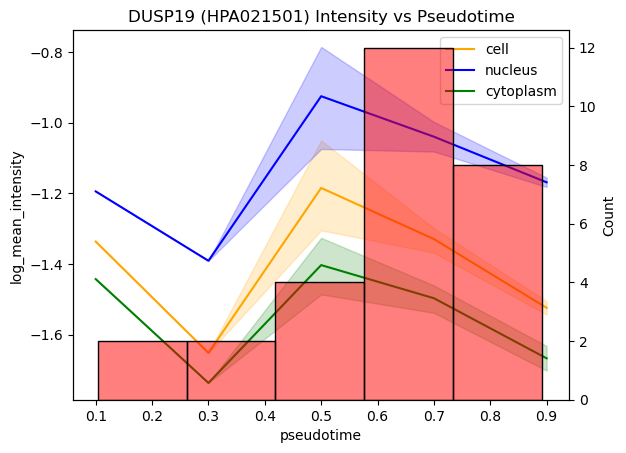

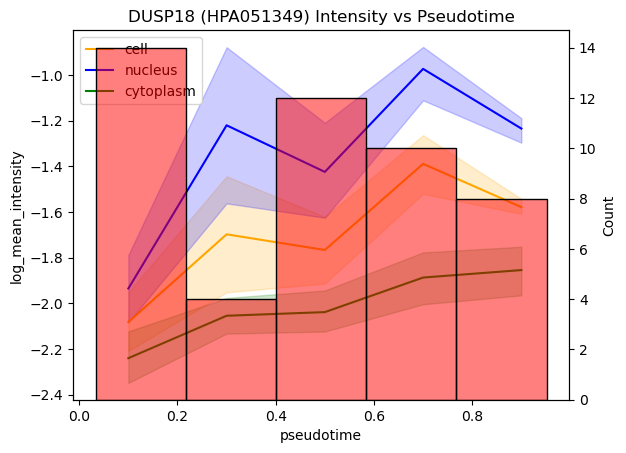

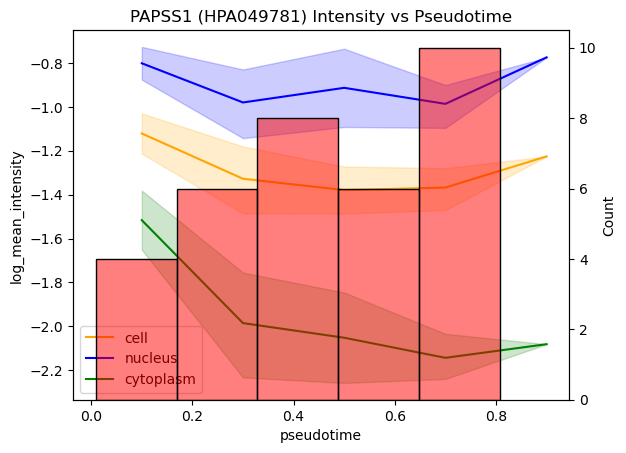

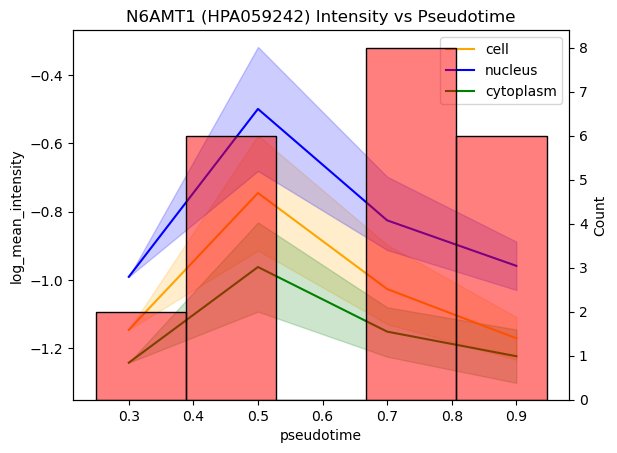

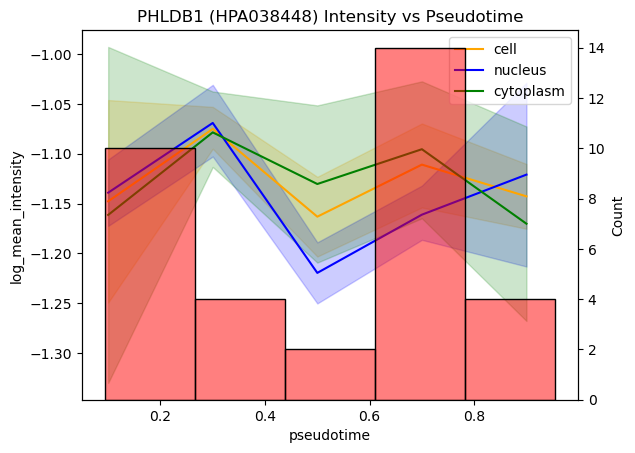

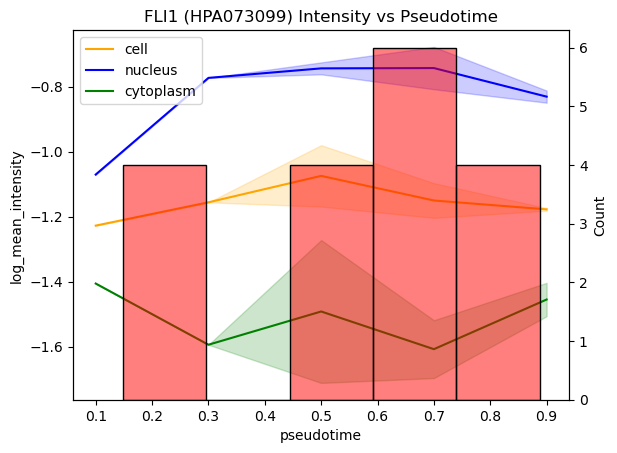

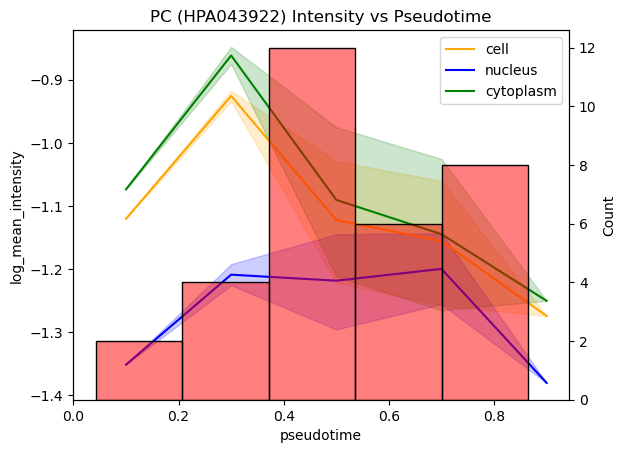

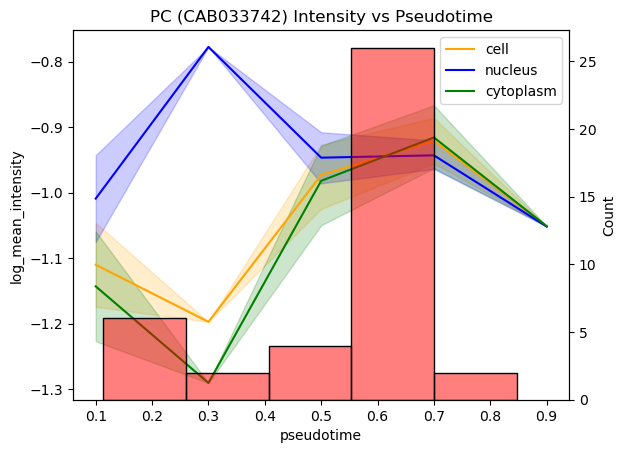

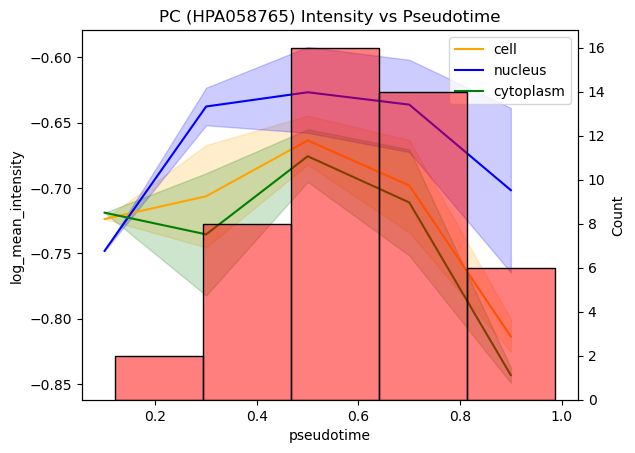

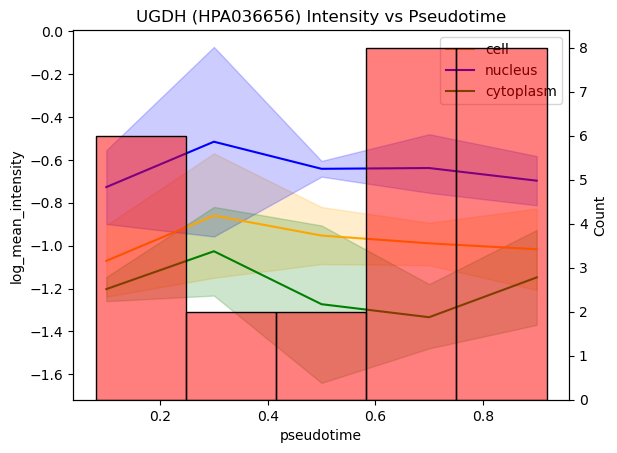

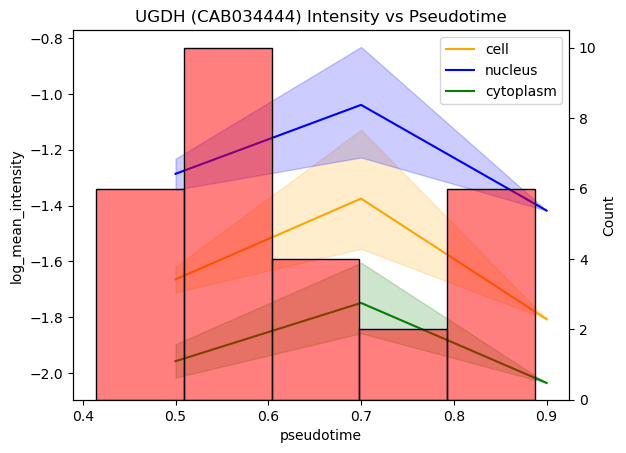

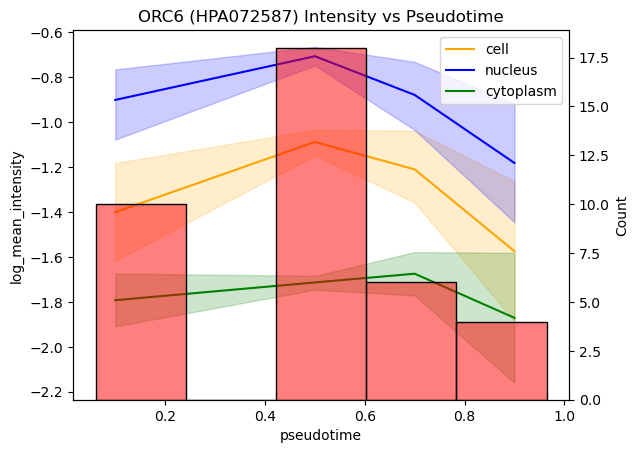

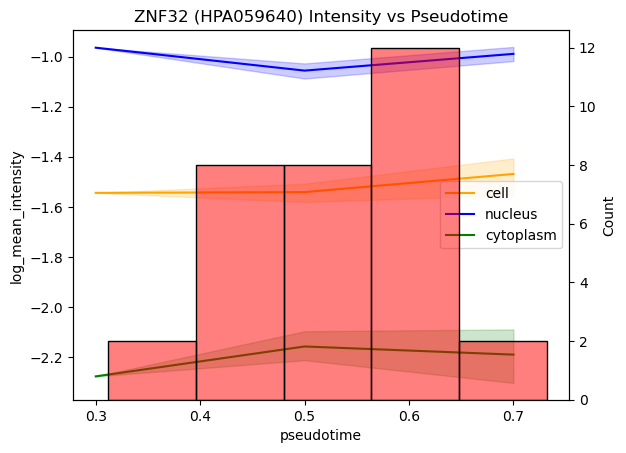

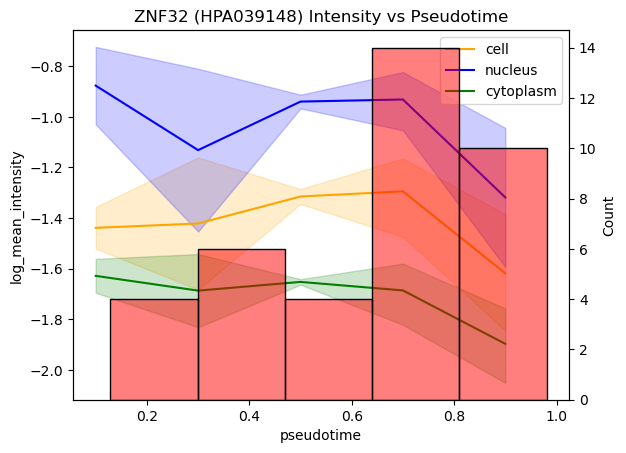

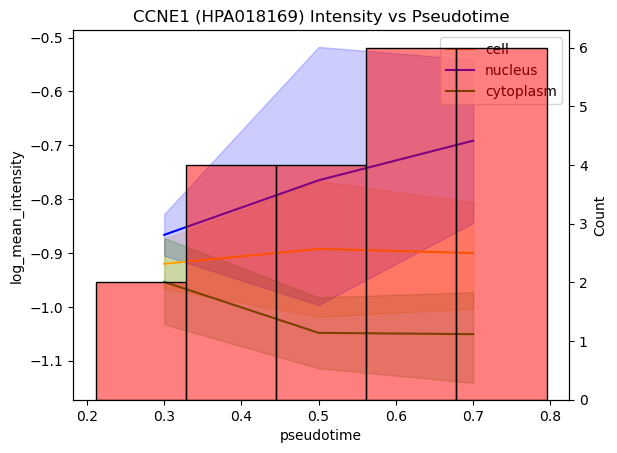

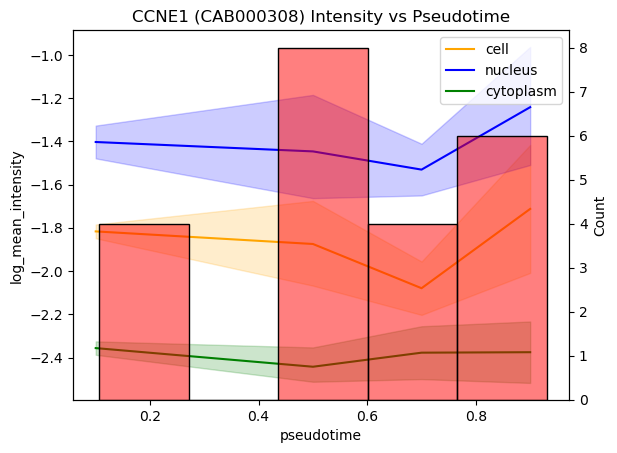

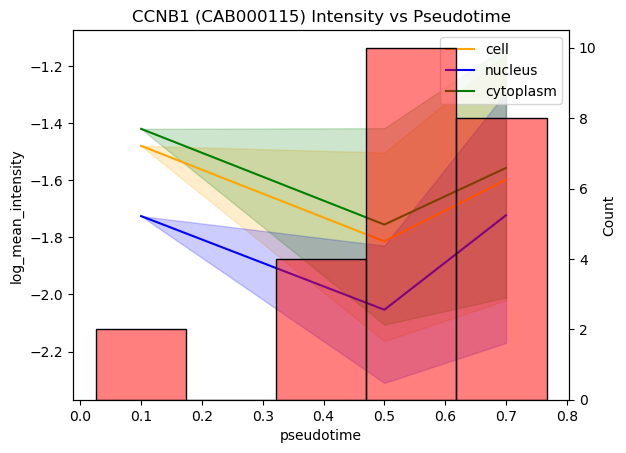

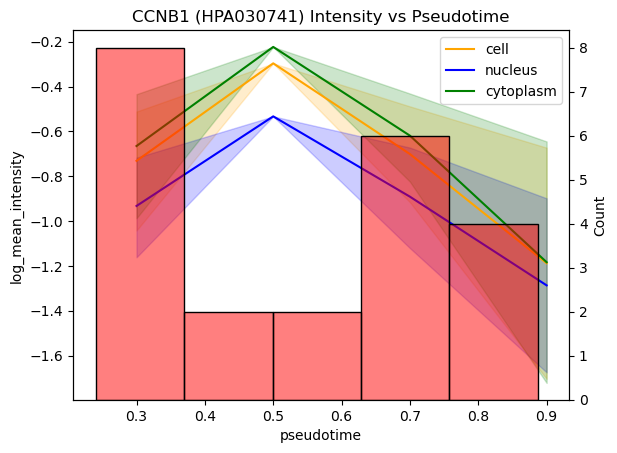

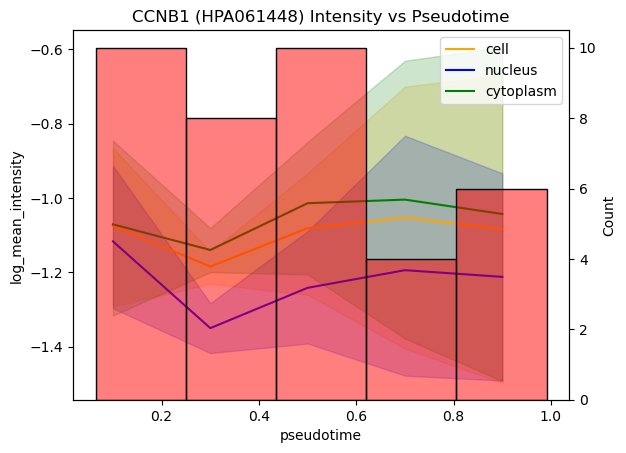

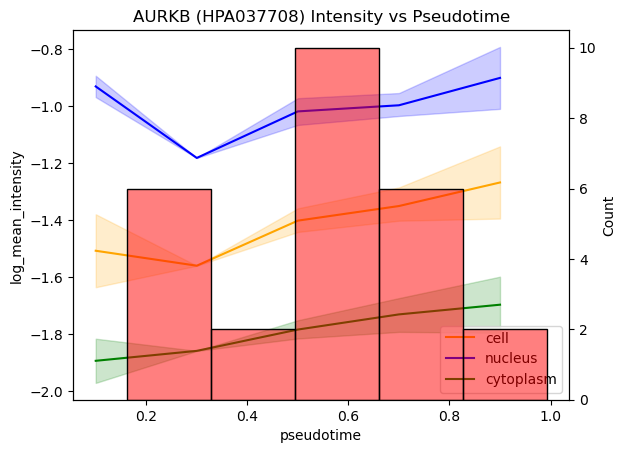

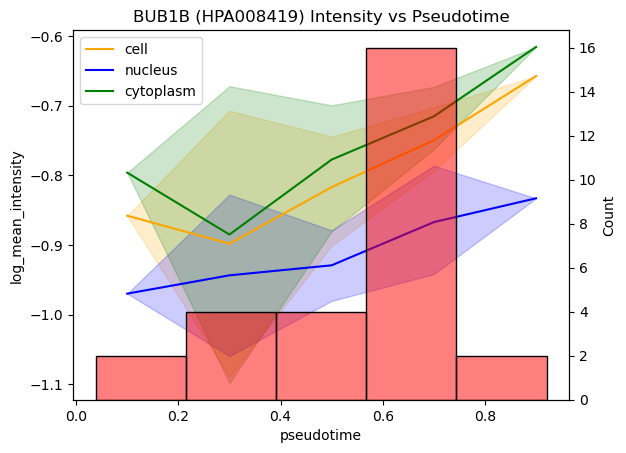

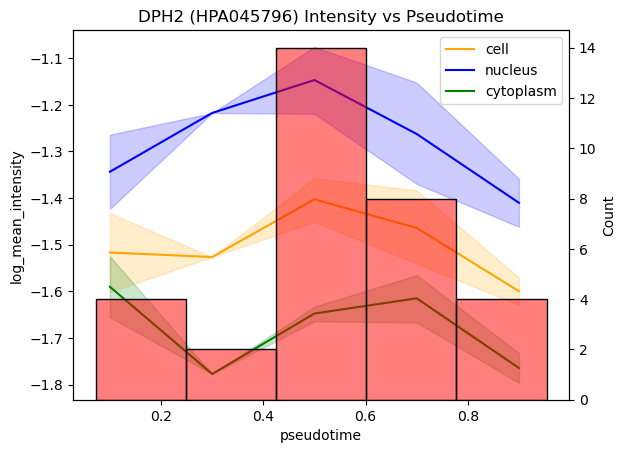

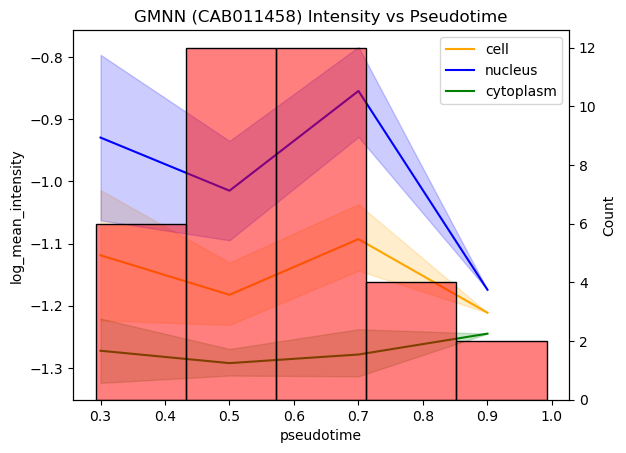

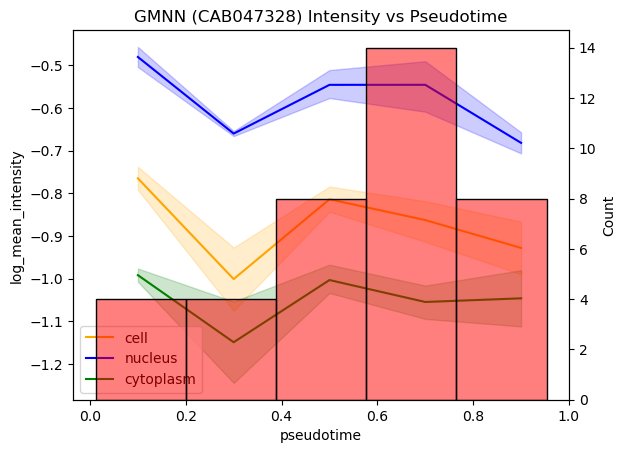

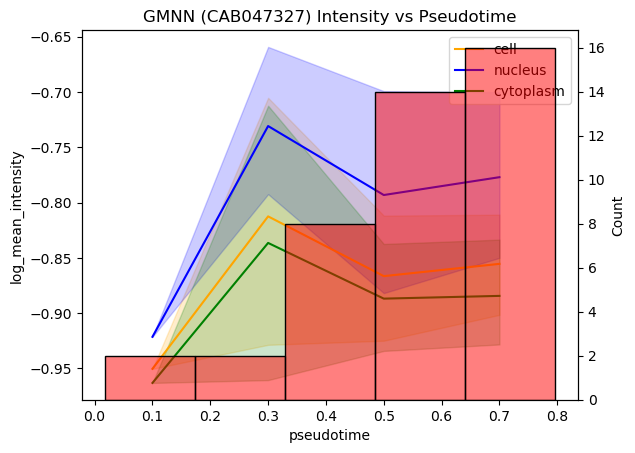

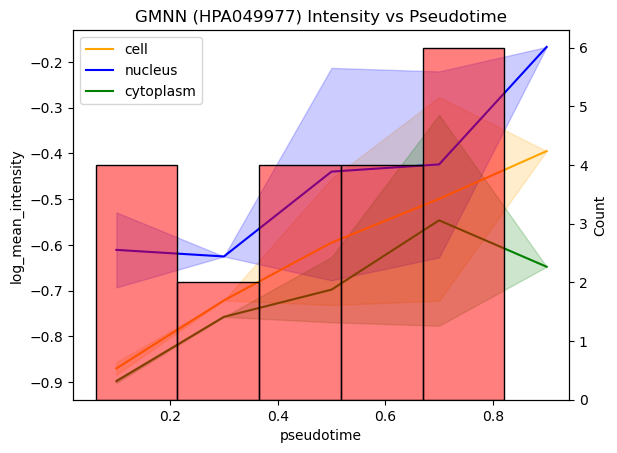

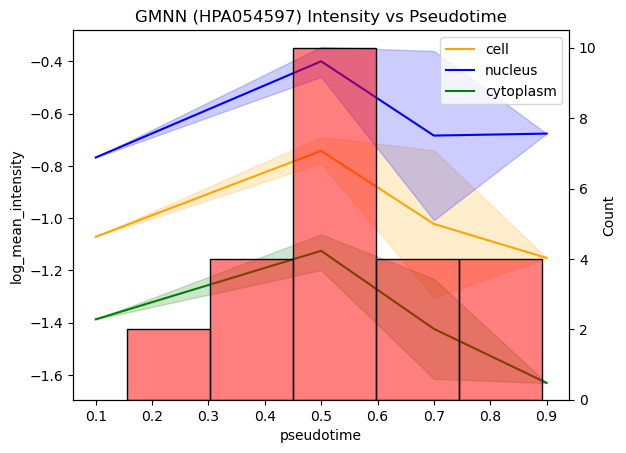

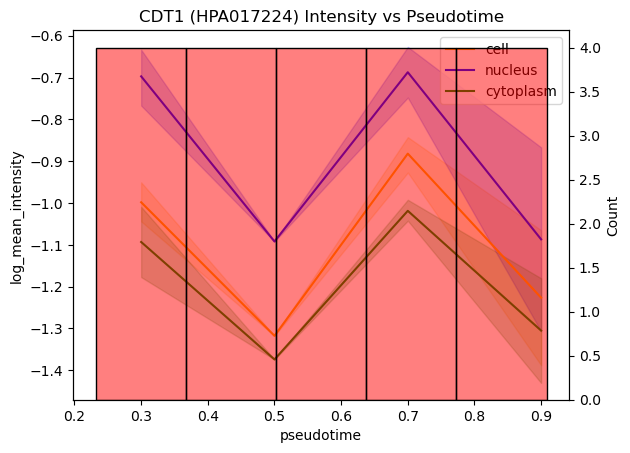

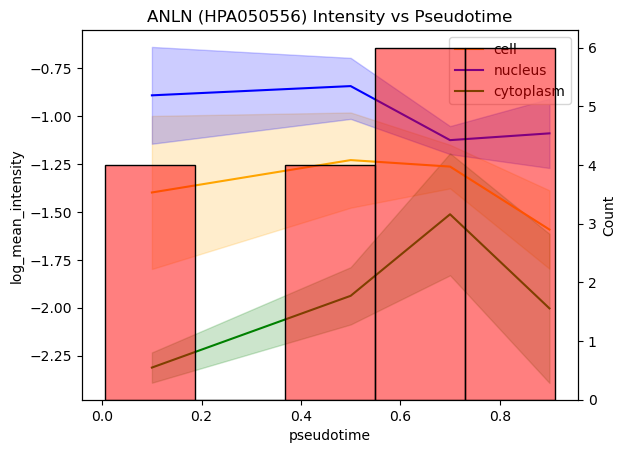

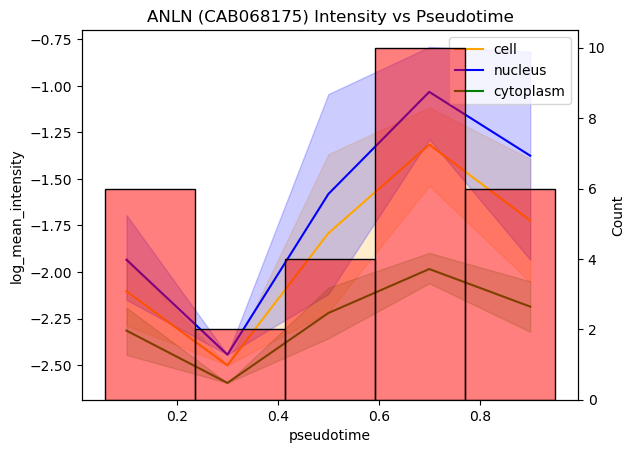

In [61]:
"""
    prot_ant_int_ps[(prot, antibody)] = {
        "pseudotime": pseudotime,
        "intensity_sums": intensity_sums,
        "non_zero_cts": non_zero_cts,
        "log_mean_intensity": log_mean_intensity,
        "log_intensity": log_intensity,
        "mean_intensity": mean_intensity
    }
"""

num_bins = 5

sample_prop = None

prot_ant_int_ps = pkl.load(open(DATA_DIR / "prot_ant_ps_stats.pkl", "rb"))

pseudotimes = []
for (prot, antibody), stats in prot_ant_int_ps.items():
    pseudotime = stats["pseudotime"].cpu().numpy().flatten()
    intensity = stats["log_mean_intensity"][:, 3].cpu().numpy()
    nuc_intensity = stats["nuc_log_mean_intensity"][:, 3].cpu().numpy()
    cyto_intensity = stats["cyto_log_mean_intensity"][:, 3].cpu().numpy()

    if sample_prop is not None and sample_prop < 1:
        sample_size = int(len(pseudotime) * sample_prop)
        sample = np.random.choice(len(pseudotime), size=sample_size, replace=False)
        pseudotime = pseudotime[sample]
        intensity = intensity[sample]
        nuc_intensity = nuc_intensity[sample]
        cyto_intensity = cyto_intensity[sample]



    pseudotimes.append(pseudotime)

    bins = np.linspace(0, 1, num_bins + 1)
    pseudotime_binned = (np.digitize(pseudotime, bins) - 1) / num_bins
    pseudotime_binned += (1 / num_bins) / 2

    df_dict = {"pseudotime": pseudotime_binned, "log_mean_intensity": intensity,
                "nuc_log_mean_intensity": nuc_intensity, "cyto_log_mean_intensity": cyto_intensity}

    prot_int_df_bin = pd.DataFrame(df_dict)
    df_dict["pseudotime"] = pseudotime
    prot_int_df = pd.DataFrame(df_dict)
    plt.clf()
    sns.lineplot(data=prot_int_df_bin, x="pseudotime", y="log_mean_intensity", errorbar=('ci', 95), label="cell", color='orange')
    sns.lineplot(data=prot_int_df_bin, x="pseudotime", y="nuc_log_mean_intensity", errorbar=('ci', 95), label="nucleus", color='blue')
    ax = sns.lineplot(data=prot_int_df_bin, x="pseudotime", y="cyto_log_mean_intensity", errorbar=('ci', 95), label="cytoplasm", color='green')
    ax2 = ax.twinx()
    sns.histplot(pseudotime, bins=num_bins, ax=ax2, alpha=0.5, color="red")
    plt.title(f"{prot} ({antibody}) Intensity vs Pseudotime")
    plt.show()

pseudotimes = np.concatenate(pseudotimes)


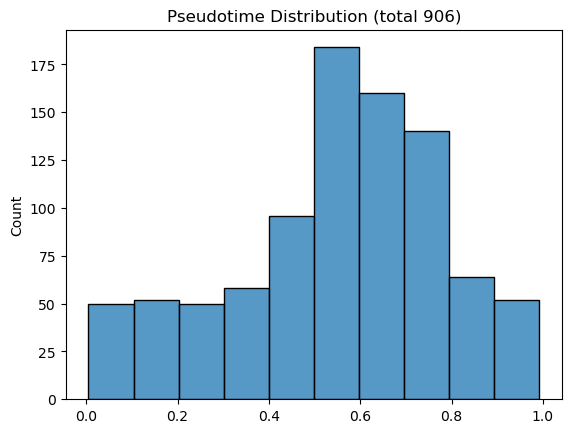

In [62]:
plt.clf()
sns.histplot(pseudotimes, bins=10)
plt.title(f"Pseudotime Distribution (total {len(pseudotimes)})")
plt.show()

torch.Size([20, 4])


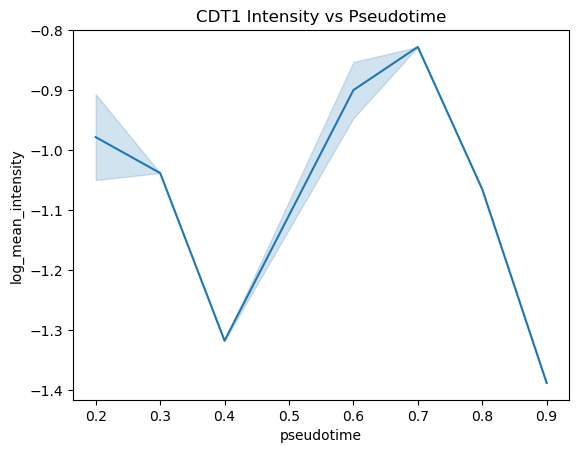

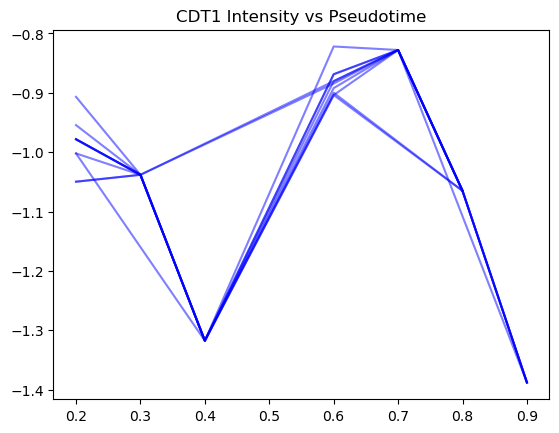

torch.Size([512, 512])
torch.Size([3, 512, 512])


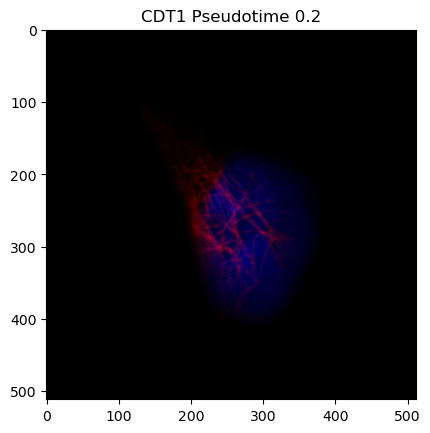

torch.Size([512, 512])
torch.Size([3, 512, 512])


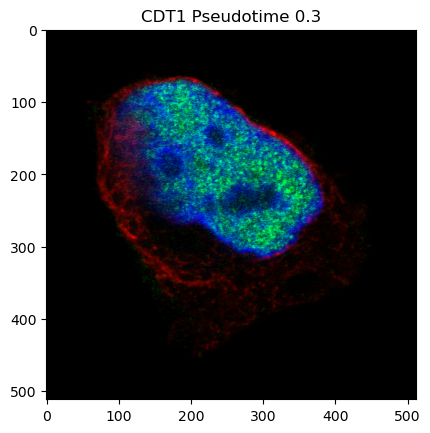

torch.Size([512, 512])
torch.Size([3, 512, 512])


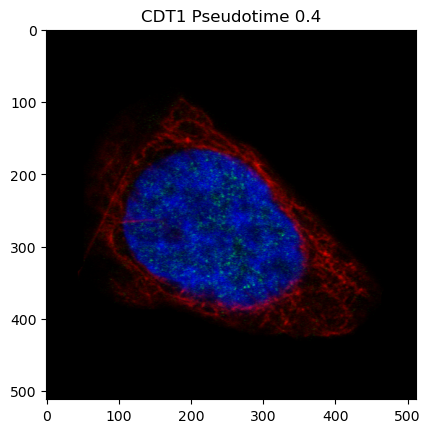

torch.Size([512, 512])
torch.Size([3, 512, 512])


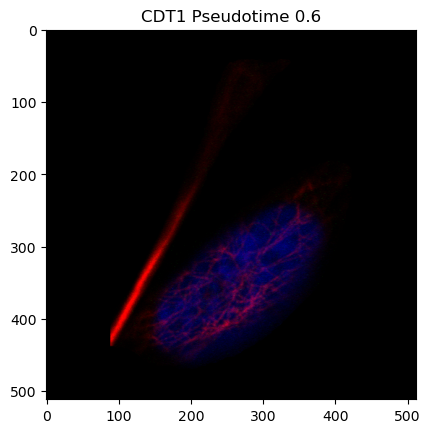

torch.Size([512, 512])
torch.Size([3, 512, 512])


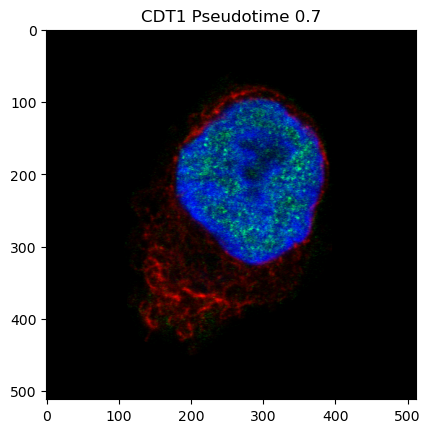

torch.Size([512, 512])
torch.Size([3, 512, 512])


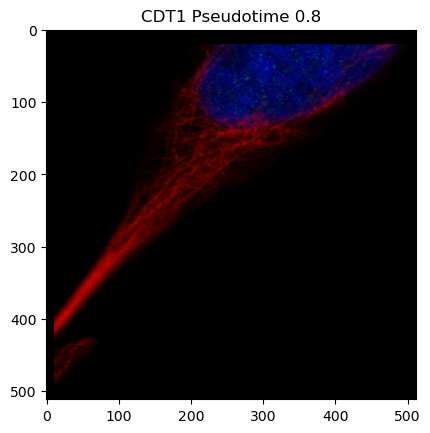

torch.Size([512, 512])
torch.Size([3, 512, 512])


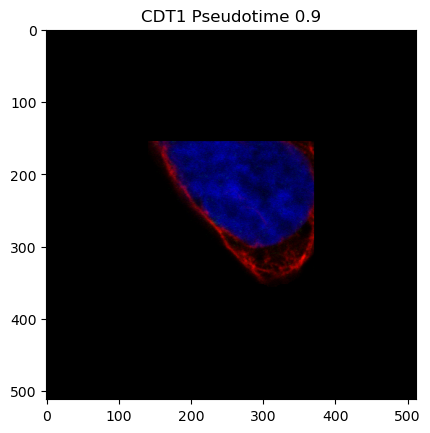

In [11]:
prot = "CDT1"
antibody = "HPA017224"

stats = prot_ant_int_ps[(prot, antibody)]
pseudotime = stats["pseudotime"].cpu().numpy().flatten()
log_intensity = stats["log_mean_intensity"]
plot_intensity = log_intensity[:, 3].cpu().numpy()
print(log_intensity.shape)

# plot intensity vs binned pseudotime
num_bins = 10
bins = np.linspace(0, 1, num_bins + 1)
pseudotime_binned = (np.digitize(pseudotime, bins) - 1) / num_bins

prot_int_df = pd.DataFrame({"pseudotime": pseudotime_binned, "log_mean_intensity": plot_intensity})
plt.clf()
sns.lineplot(data=prot_int_df, x="pseudotime", y="log_mean_intensity", errorbar=('ci', 95))
plt.title(f"{prot} Intensity vs Pseudotime")
plt.show()

# randomly sample half of the data and plot the intensity vs binned pseudotime, repeat 10 times
plt.clf()
for i in range(10):
    sample = np.random.choice(len(pseudotime_binned), len(pseudotime_binned) // 2, replace=False)
    prot_int_df = pd.DataFrame({"pseudotime": pseudotime_binned[sample], "log_mean_intensity": plot_intensity[sample]})
    prot_int_df = prot_int_df.groupby("pseudotime").mean().reset_index()
    prot_int_df = prot_int_df.sort_values(by=["pseudotime"])
    # sns.lineplot(data=prot_int_df, x="pseudotime", y="log_mean_intensity", color="blue", alpha=0.5)
    plt.plot(prot_int_df["pseudotime"], prot_int_df["log_mean_intensity"], color="blue", alpha=0.5)
plt.title(f"{prot} Intensity vs Pseudotime")
plt.show()

# pick a random sample from each pseudotime bin and display the image from the dataset
for i in range(num_bins):
    try:
        sample = np.where(pseudotime_binned == i / num_bins)[0][0]
    except IndexError:
        continue
    plt.clf()
    dapi, tubl, er, anti = dataset[sample]
    print(dapi.shape)
    image = torch.stack([tubl, anti, dapi], dim=0)
    print(image.shape)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"{prot} Pseudotime {i / num_bins}")
    plt.show()

# Intensity Exploration

In [12]:
eval_percentiles = [0, 1, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 75, 80, 85, 90, 95, 99, 100]
resolution = 8 # bit
buckets = 2 ** resolution
eval_percentiles = np.array(list(range(0, buckets, 1))) / (buckets - 1) * 100

percentiles_path = DATA_DIR / f"well_percentiles_{buckets}.npy"
well_percentiles = np.load(percentiles_path)

FUCCI_DATA_DIR = Path("/data/ishang/FUCCI-dataset-well/")
# fucci_well_percentiles = np.load(FUCCI_DATA_DIR / f"well_percentiles_{buckets}.npy")
fucci_well_percentiles = np.load(FUCCI_DATA_DIR / "normalized_well_percentiles.npy")

well_percentiles = well_percentiles[:, 2:]
fucci_well_percentiles = fucci_well_percentiles[:, 2:]

30


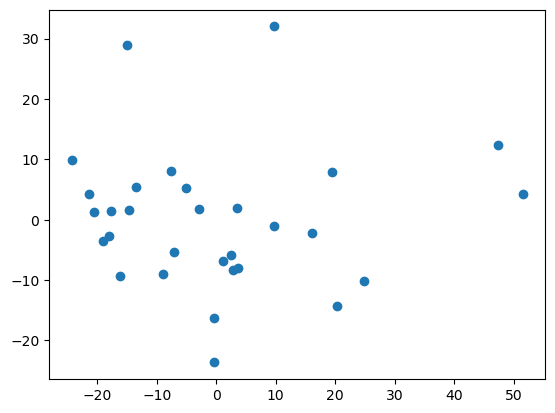

Explained variance ratio: [6.75316072e-01 2.55336769e-01 2.33068566e-02 1.69020980e-02
 8.82111405e-03 6.67271895e-03 4.22446259e-03 2.76509383e-03
 2.11688863e-03 1.62139710e-03 1.06710750e-03 7.97034657e-04
 3.30556010e-04 2.86116972e-04 1.69946701e-04]


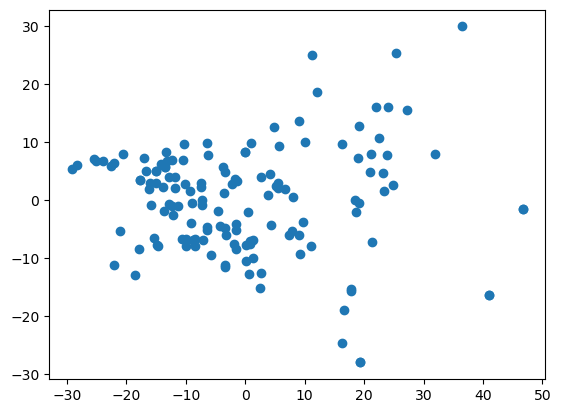

Explained variance ratio: [0.498168   0.1727963  0.11320157 0.04889305 0.04444931 0.03050339
 0.02028004 0.01287781 0.00994174 0.00743589 0.00578768 0.00483992
 0.00449109 0.00309951 0.00253697]


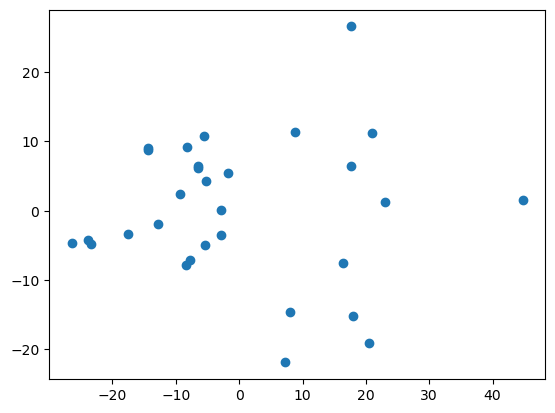

Explained variance ratio: [0.52285661 0.20189015 0.11118527 0.06004068 0.02980412 0.0209954
 0.01189198 0.00998198 0.00852302 0.00469357 0.00397287 0.0027562
 0.00244143 0.00197287 0.00180834]


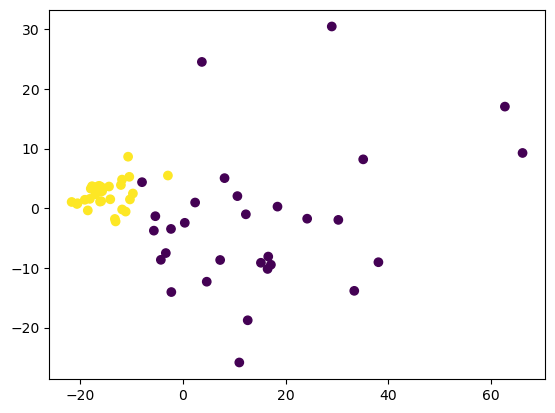

Explained variance ratio: [7.75874734e-01 1.48813038e-01 3.20254887e-02 1.51529696e-02
 7.80777921e-03 4.33489006e-03 3.80892028e-03 2.93853526e-03
 2.25941727e-03 1.79664922e-03 1.55279888e-03 1.38015236e-03
 7.13601604e-04 4.47952314e-04 2.71251449e-04]


(PCA(n_components=15), StandardScaler())

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def percentiles_PCA(well_percentiles, color=None):
    well_percentiles = well_percentiles.reshape(well_percentiles.shape[0], -1) # W x (C * P)
    scaler = StandardScaler()
    scaled_well_percentiles = scaler.fit_transform(well_percentiles)
    pca = PCA(n_components=15)
    well_pca = pca.fit_transform(scaled_well_percentiles)
    plt.clf()
    if color is None:
        plt.scatter(well_pca[:, 0], well_pca[:, 1])
    else:
        plt.scatter(well_pca[:, 0], well_pca[:, 1], c=color)
    plt.show()

    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    return pca, scaler

fucci_well_samples = np.random.choice(len(fucci_well_percentiles), len(well_percentiles), replace=False)
# fucci_well_samples = np.arange(len(fucci_well_percentiles))
colors = [0] * len(well_percentiles) + [1] * len(fucci_well_samples)
print(len(fucci_well_samples))
percentiles_PCA(well_percentiles)
percentiles_PCA(fucci_well_percentiles)
percentiles_PCA(fucci_well_percentiles[fucci_well_samples])
percentiles_PCA(np.concatenate([well_percentiles, fucci_well_percentiles[fucci_well_samples]], axis=0), color=colors)

# CLS Exploration

In [14]:
hpa_cls_tokens = torch.load(DATA_DIR / "ref_cls_tokens.pt")

In [15]:
FUCCI_DATA_DIR = Path("/data/ishang/FUCCI-dataset-well/")
FUCCI_NAME = "well_spline_norm_512_crop_sharpness_1250"
fucci_dataset = CellImageDataset(FUCCI_DATA_DIR / f"index_{FUCCI_NAME}.csv", channel_colors=["pure_blue", "pure_yellow", "pure_red", "pure_green"], batch_size=batch_size)
fucci_cls_tokens = dino.predict_cls(fucci_dataset).detach().cpu()

Loading dataset images: 100%|██████████| 5/5 [01:38<00:00, 19.69s/it]


Loaded 33933 images from 142 files.


100%|██████████| 340/340 [01:57<00:00,  2.88it/s]


In [42]:
# load the pseudotime predictions for the HPA images and the FUCCI images
hpa_pseudotimes = []
for (prot, antibody), stats in prot_ant_int_ps.items():
    pseudotime = stats["pseudotime"].cpu().numpy().flatten()
    hpa_pseudotimes.append(pseudotime)

hpa_pseudotimes = np.concatenate(hpa_pseudotimes)

fucci_pseudotimes_labels = np.load(FUCCI_DATA_DIR / f"FUCCI_pseudotime_{FUCCI_NAME}.npy")
fucci_pseudotimes_preds = np.load(FUCCI_DATA_DIR / f"FUCCI_pseudotime_pred_{FUCCI_NAME}.npy")

(906,) float64
(906,) float64
(906,) float64
906 906
True


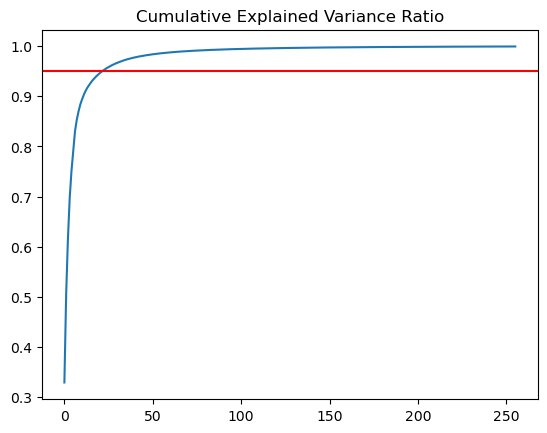

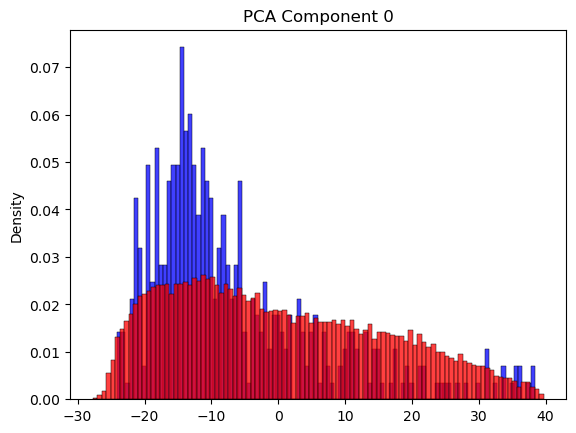

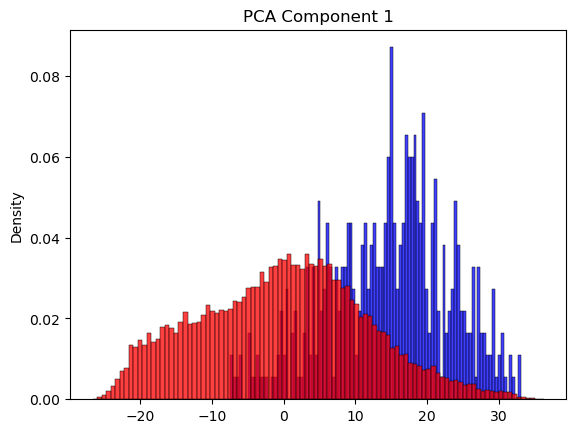

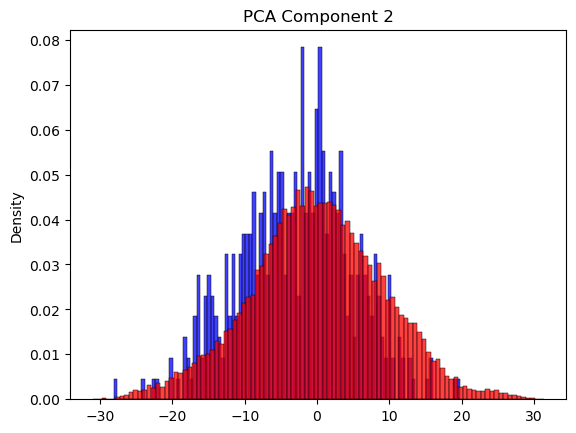

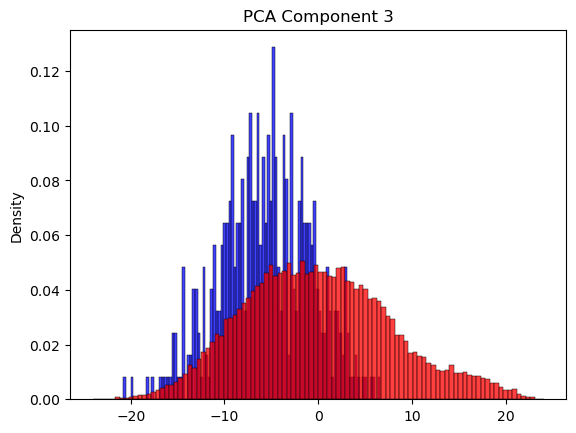

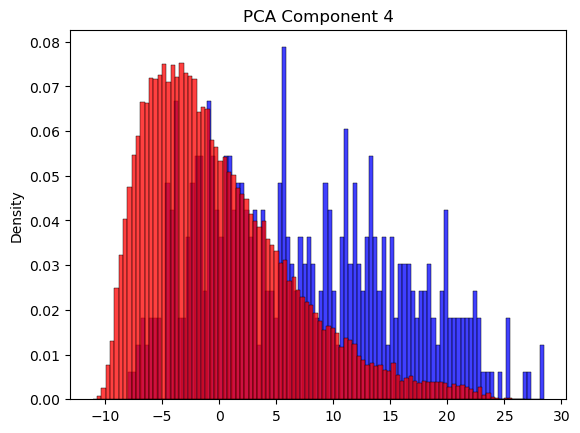

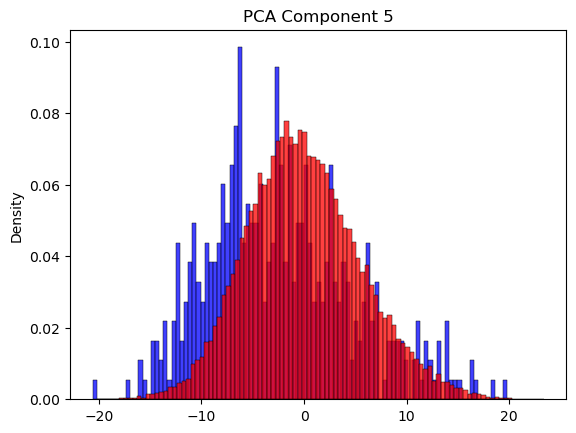

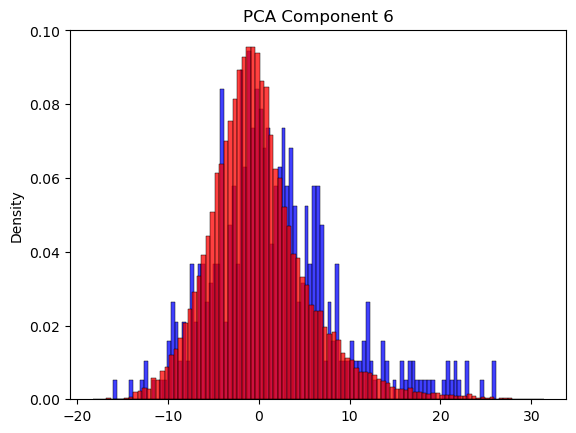

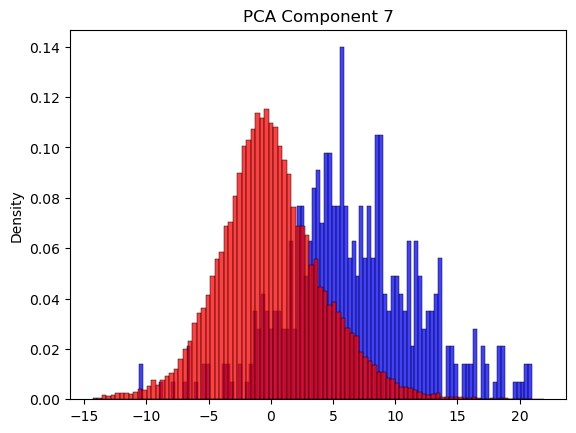

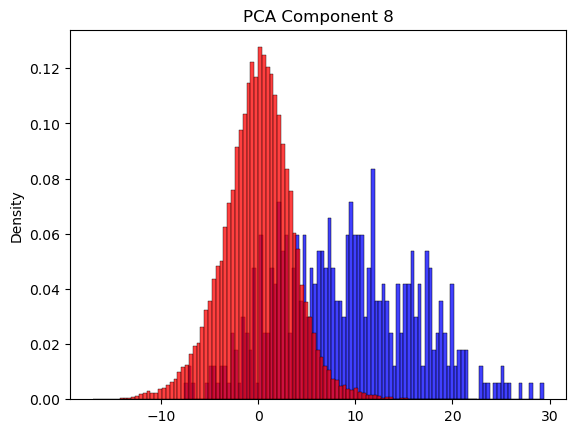

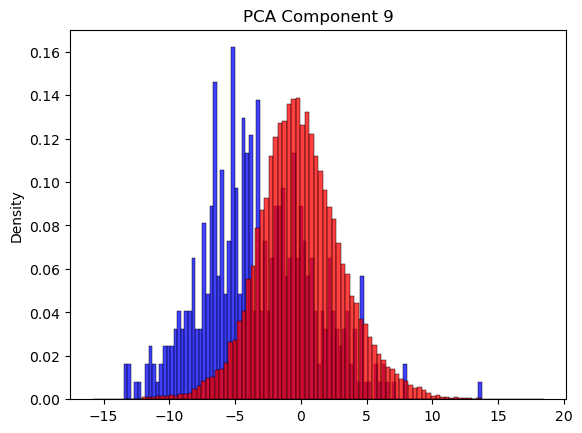

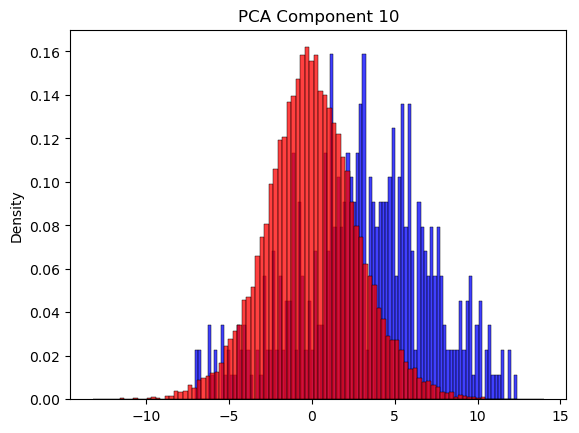

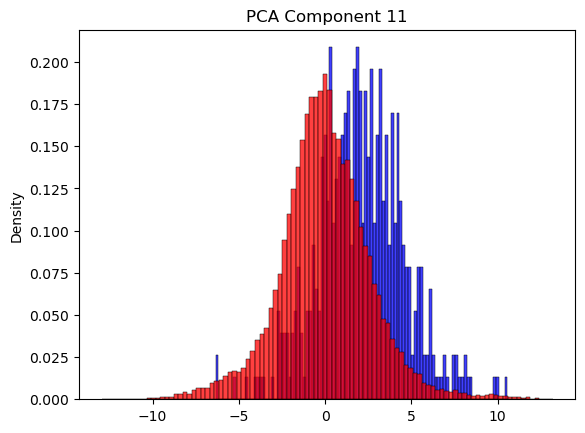

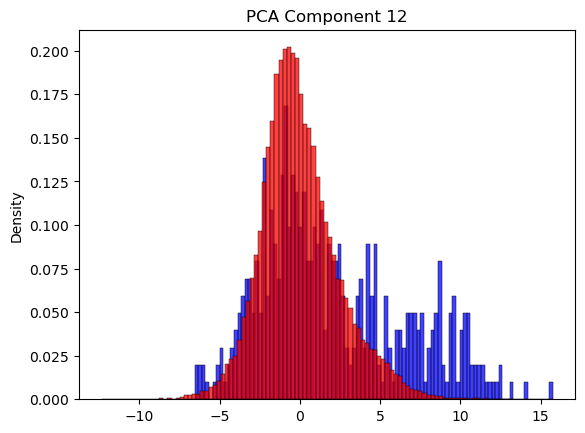

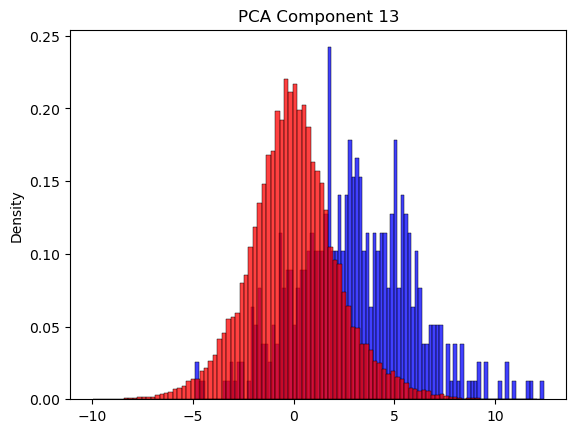

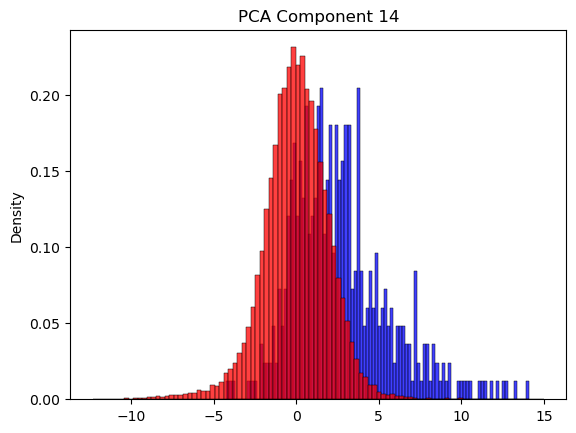

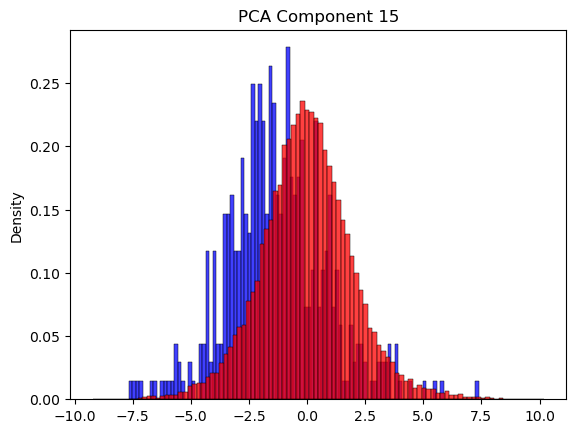

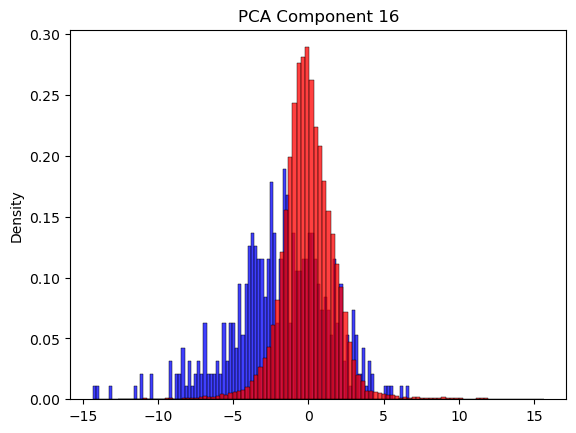

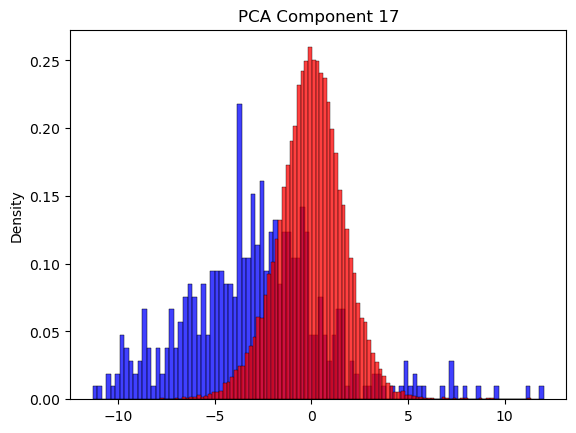

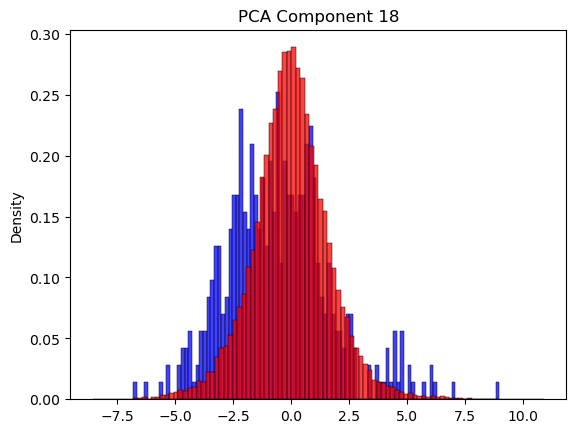

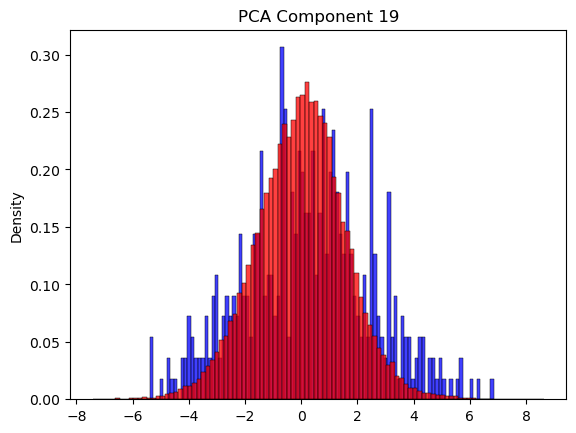

In [46]:
# PCA of the two groups of cls tokens, colored by the source
colors = [0] * len(hpa_cls_tokens) + [1] * len(fucci_cls_tokens)
cls_tokens = torch.cat([hpa_cls_tokens, fucci_cls_tokens], dim=0)

scaler = StandardScaler()
pca = PCA(n_components=256)

scaler.fit(cls_tokens[len(hpa_cls_tokens):])
scaled_cls_tokens = scaler.transform(cls_tokens)

pca.fit(scaled_cls_tokens[len(hpa_cls_tokens):])
cls_pca = pca.transform(scaled_cls_tokens)

print(cls_pca[:len(hpa_cls_tokens), 0].shape, cls_pca[:len(hpa_cls_tokens), 0].dtype)
print(cls_pca[:len(hpa_cls_tokens), 1].shape, cls_pca[:len(hpa_cls_tokens), 1].dtype)
print(hpa_pseudotimes.shape, hpa_pseudotimes.astype('float64').dtype)
print(len(np.ma.ravel(hpa_pseudotimes)), cls_pca[:len(hpa_cls_tokens), 0].size)
print(np.issubdtype(hpa_pseudotimes.dtype, np.floating))


# cdf of explained variance ratio
plt.clf()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Cumulative Explained Variance Ratio")
plt.axhline(y=0.95, color='r', linestyle='-')
plt.show()

# plot normalized histograms for the two groups of cls tokens for the first 20 components
for i in range(20):
    plt.clf()
    sns.histplot(cls_pca[:len(hpa_cls_tokens), i], bins=100, color="blue", label="HPA", stat="density")
    sns.histplot(cls_pca[len(hpa_cls_tokens):, i], bins=100, color="red", label="FUCCI", stat="density")
    plt.title(f"PCA Component {i}")
    plt.show()

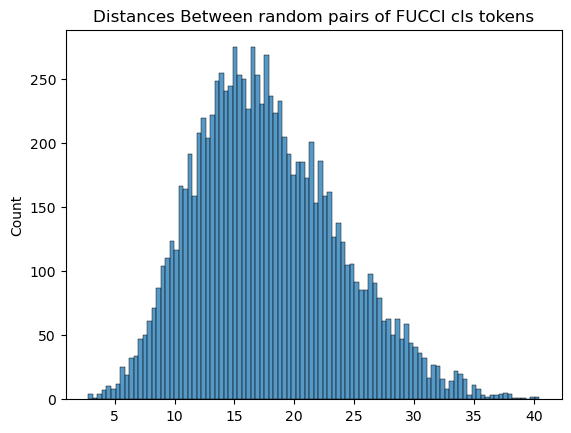

In [65]:
# plot the distribution of distances between cls tokens from the FUCCI dataset
sample_size = 10000
sample_left = np.random.choice(len(fucci_cls_tokens), sample_size, replace=False)
sample_right = np.random.choice(len(fucci_cls_tokens), sample_size, replace=False)
sample_left = fucci_cls_tokens[sample_left]
sample_right = fucci_cls_tokens[sample_right]
distances = torch.norm(sample_left - sample_right, dim=1)

plt.clf()
sns.histplot(distances, bins=100)
plt.title("Distances Between random pairs of FUCCI cls tokens")
plt.show()

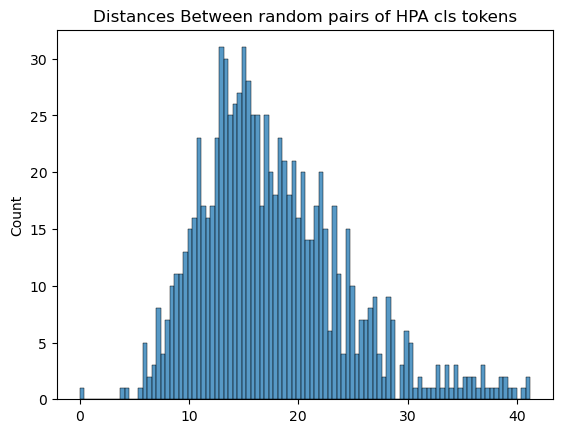

In [66]:
# plot the distribution of distances between cls tokens from the HPA dataset
sample_size = len(hpa_cls_tokens)
sample_left = np.random.choice(len(hpa_cls_tokens), sample_size, replace=False)
sample_right = np.random.choice(len(hpa_cls_tokens), sample_size, replace=False)
sample_left = hpa_cls_tokens[sample_left]
sample_right = hpa_cls_tokens[sample_right]
distances = torch.norm(sample_left - sample_right, dim=1)

plt.clf()
sns.histplot(distances, bins=100)
plt.title("Distances Between random pairs of HPA cls tokens")
plt.show()

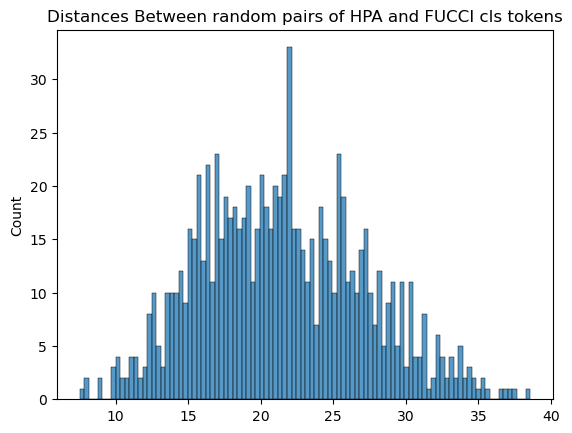

In [67]:
# plot the distribution of distances between cls tokens from the HPA and FUCCI datasets
sample_size = len(hpa_cls_tokens)
sample_left = np.random.choice(len(hpa_cls_tokens), sample_size, replace=False)
sample_right = np.random.choice(len(fucci_cls_tokens), sample_size, replace=False)
sample_left = hpa_cls_tokens[sample_left]
sample_right = fucci_cls_tokens[sample_right]
distances = torch.norm(sample_left - sample_right, dim=1)

plt.clf()
sns.histplot(distances, bins=100)
plt.title("Distances Between random pairs of HPA and FUCCI cls tokens")
plt.show()

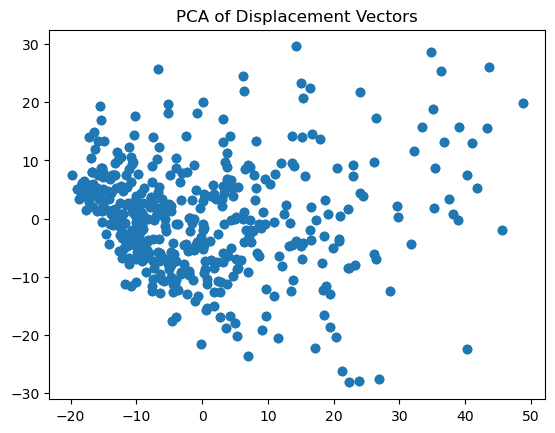

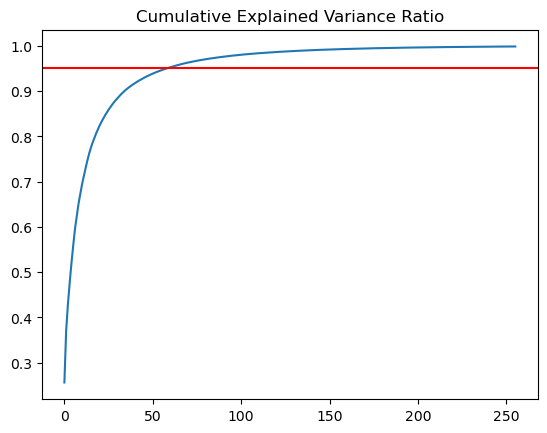

In [79]:
# find the nearest neighbor of each HPA cls token in the FUCCI cls tokens and plot the PCA of the displacement vectors
from sklearn.neighbors import NearestNeighbors
n_neighbors = 20
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(fucci_cls_tokens)
distances, indices = nbrs.kneighbors(hpa_cls_tokens)

displacement = fucci_cls_tokens[indices] - hpa_cls_tokens[:, None]
displacement = torch.mean(displacement, dim=1)
scaler = StandardScaler()
pca = PCA(n_components=256)
displacement = scaler.fit_transform(displacement)
displacement = pca.fit_transform(displacement)

plt.clf()
plt.scatter(displacement[:, 0], displacement[:, 1])
plt.title("PCA of Displacement Vectors")
plt.show()

# plot the cumulative explained variance ratio
plt.clf()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Cumulative Explained Variance Ratio")
plt.axhline(y=0.95, color='r', linestyle='-')
plt.show()


In [82]:
fucci_sample = np.random.choice(len(fucci_cls_tokens), len(fucci_cls_tokens) // 2, replace=False)
fucci_rest = np.setdiff1d(np.arange(len(fucci_cls_tokens)), fucci_sample)
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(fucci_cls_tokens[fucci_sample])
distances, fucci_indices = nbrs.kneighbors(fucci_cls_tokens[fucci_rest])
distances, hpa_indices = nbrs.kneighbors(hpa_cls_tokens)

fucci_displacement = fucci_cls_tokens[fucci_indices] - fucci_cls_tokens[fucci_rest][:, None]
fucci_displacement = torch.mean(fucci_displacement, dim=1)
scaler = StandardScaler()
pca = PCA(n_components=256)
fucci_displacement = scaler.fit_transform(fucci_displacement)
fucci_displacement = pca.fit_transform(fucci_displacement)

hpa_displacement = fucci_cls_tokens[hpa_indices] - hpa_cls_tokens[:, None]
hpa_displacement = torch.mean(hpa_displacement, dim=1)
hpa_displacement = scaler.transform(hpa_displacement)
hpa_displacement = pca.transform(hpa_displacement)

plt.clf()
plt.scatter(fucci_displacement[:, 0], fucci_displacement[:, 1], color="red", label="FUCCI", alpha=0.2)
plt.scatter(hpa_displacement[:, 0], hpa_displacement[:, 1], color="blue", label="HPA", alpha=0.2)
plt.title("PCA of Displacement Vectors")
plt.legend()
plt.show()

# plot the cumulative explained variance ratio
plt.clf()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Cumulative Explained Variance Ratio")
plt.axhline(y=0.95, color='r', linestyle='-')
plt.show()

# plot the histograms for each for the first 10 components
for i in range(10):
    plt.clf()
    sns.histplot(fucci_displacement[:, i], bins=100, color="red", label="FUCCI", stat="density")
    sns.histplot(hpa_displacement[:, i], bins=100, color="blue", label="HPA", stat="density")
    plt.title(f"PCA Component {i}")
    plt.show()

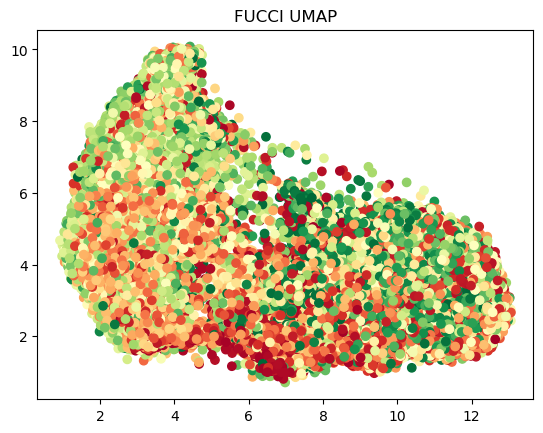

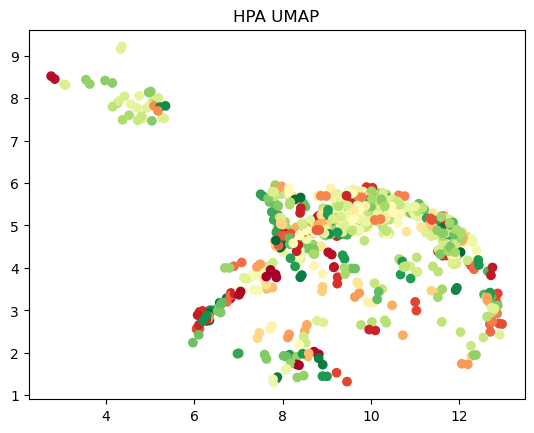

In [49]:
# plot umaps of the two groups of cls tokens, colored by the source
# plot both using the umap transformation of the FUCCI data

import umap

reducer = umap.UMAP()
sample = np.random.choice(len(fucci_cls_tokens), 1000, replace=False) + len(hpa_cls_tokens)
reducer.fit(scaled_cls_tokens[sample])
fucci_umap = reducer.transform(scaled_cls_tokens[len(hpa_cls_tokens):])

plt.clf()
plt.scatter(fucci_umap[:, 0], fucci_umap[:, 1], c=fucci_pseudotimes_labels, cmap="RdYlGn")
plt.title("FUCCI UMAP")
plt.show()

hpa_umap = reducer.transform(scaled_cls_tokens[:len(hpa_cls_tokens)])

plt.clf()
plt.scatter(hpa_umap[:, 0], hpa_umap[:, 1], c=hpa_pseudotimes, cmap="RdYlGn")
plt.title("HPA UMAP")
plt.show()

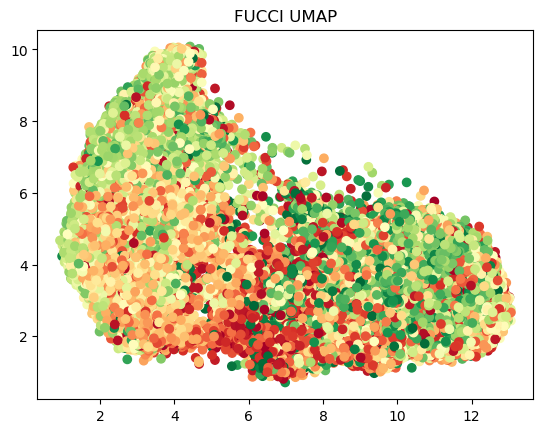

In [50]:
plt.clf()
plt.scatter(fucci_umap[:, 0], fucci_umap[:, 1], c=fucci_pseudotimes_preds, cmap="RdYlGn")
plt.title("FUCCI UMAP")
plt.show()